In [3]:
# see Leo's analysis here: https://github.com/saezlab/best_practices_ParTIpy/tree/main
from pathlib import Path

import plotnine as pn
import scanpy as sc
import partipy as pt

import harmonypy as hm


figure_dir = Path("figures") / "fibroblast_cross_condition"
figure_dir.mkdir(exist_ok=True, parents=True)
sc.settings.figdir = figure_dir

output_dir = Path("output") / "fibroblast_cross_condition"
output_dir.mkdir(exist_ok=True, parents=True)

adata = pt.read_h5ad("/home/pschaefer/fibroblast_cross_condition_partipy.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 147219 × 28616
    obs: 'biosample_id', 'donor_id', 'disease', 'sex', 'age', 'lvef', 'cell_type_leiden0.6', 'SubCluster', 'cellbender_ncount', 'cellbender_ngenes', 'cellranger_percent_mito', 'exon_prop', 'cellbender_entropy', 'cellranger_doublet_scores', 'n_genes', 'disease_original'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'AA_bootstrap', 'AA_cell_weights', 'AA_config', 'AA_pca', 'AA_results', 'AA_selection_metrics', 'hvg', 'log1p', 'pca'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'cellranger_raw', 'z_scaled'

In [ ]:
import pandas as pd

arch_expr_long = pd.read_csv(
    "output/fibroblast_cross_condition/archetype_expression.csv"
)
arch_expr_long

,gene,variable,value
0,AL627309.1,arch_0,-0.021044
1,AL627309.5,arch_0,-0.018581
2,AP006222.2,arch_0,-0.019059
3,LINC01409,arch_0,0.029218
4,FAM87B,arch_0,-0.019811
...,...,...,...
64012,MAFIP,arch_2,-0.021464
64013,AC011043.1,arch_2,-0.005520
64014,AL354822.1,arch_2,-0.009431
64015,AL592183.1,arch_2,0.006031


In [14]:
adata.layers.keys()

KeysView(Layers with keys: cellranger_raw, z_scaled)

In [ ]:
import pandas as pd

gene_mask = adata.var_names[adata.var["n_cells"] > 100].to_list()

arch_expr = {
    "raw": pt.compute_archetype_expression(adata=adata, layer="cellranger_raw")[
        gene_mask
    ],
    "log1p": pt.compute_archetype_expression(adata=adata, layer=None)[
        gene_mask
    ],  # assumes log1p in .X
    "z_scaled": pt.compute_archetype_expression(adata=adata, layer="z_scaled")[
        gene_mask
    ],
}

long_parts = []
for scale, df_wide in arch_expr.items():
    part = (
        df_wide.rename_axis(index="archetype")  # name index
        .reset_index()  # archetype column
        .melt(id_vars="archetype", var_name="gene", value_name="value")
    )
    part["archetype"] = part["archetype"].map(lambda a: f"arch_{a}")  # optional
    part["scale"] = scale
    long_parts.append(part)

arch_expr_long = pd.concat(long_parts, ignore_index=True)

arch_expr_long = arch_expr_long.pivot_table(
    values="value", index=["archetype", "gene"], columns="scale"
).reset_index()
arch_expr_long.columns.name = None

# Optional: stable column order
col_order = ["archetype", "gene", "raw", "log1p", "z_scaled"]
arch_expr_long = arch_expr_long.reindex(
    columns=[c for c in col_order if c in arch_expr_long.columns]
)

arch_expr_long.to_csv(output_dir / "archetype_expression_pivot.csv", index=False)

In [30]:
arch_expr_long

,archetype,gene,raw,log1p,z_scaled
0,arch_0,A1BG,0.014280,0.008442,0.003555
1,arch_0,A1BG-AS1,0.014236,0.008320,0.003246
2,arch_0,A2M,0.133045,0.065756,0.004965
3,arch_0,A2M-AS1,0.004859,0.001613,-0.017950
4,arch_0,A2ML1,0.010335,0.006386,-0.007395
...,...,...,...,...,...
64012,arch_2,ZXDC,0.207829,0.114338,-0.005410
64013,arch_2,ZYG11A,0.004203,0.002438,-0.019226
64014,arch_2,ZYG11B,0.165902,0.091239,0.006609
64015,arch_2,ZYX,0.041831,0.022254,-0.020760


In [ ]:
arch_expr_long_filtered = arch_expr_long.loc[arch_expr_long["raw"] >= 1.0, :].copy()

for arch, df_arch in arch_expr_long_filtered.sort_values(
    "z_scaled", ascending=False
).groupby("archetype"):
    print(f"\n=== {arch} | Top 30 genes (z-scaled) ===")
    print(
        df_arch.loc[:, ["gene", "z_scaled", "log1p", "raw"]]
        .head(30)
        .to_string(index=False)
    )


=== arch_0 | Top 30 genes (z-scaled) ===
      gene  z_scaled    log1p      raw
     POSTN  0.688284 0.668207 3.172734
     FGF14  0.620461 1.075223 3.799818
     THBS4  0.576661 0.597333 1.962937
   FAM155A  0.514040 0.399900 1.364622
     PALLD  0.443798 0.435300 2.347044
     KALRN  0.408636 0.386280 1.016104
   LDLRAD4  0.401702 0.543944 1.269073
      UACA  0.370963 0.633110 1.540011
     LTBP2  0.360612 0.652259 1.727267
    PLXDC2  0.359460 1.451490 5.709208
      NOX4  0.312182 0.762408 2.379774
       FN1  0.301830 0.800988 3.156212
   COL12A1  0.294988 0.551567 1.355757
  MIR100HG  0.294954 0.648581 1.599939
     TSHZ2  0.282763 0.816873 2.475770
      AFF3  0.282744 0.704058 1.874181
     MEF2A  0.282244 0.388265 1.024674
     MYO1D  0.276175 0.589835 1.422271
    COL1A2  0.270470 0.689426 1.756651
AL590807.1  0.258234 0.759605 2.360654
     SGIP1  0.238208 0.604535 1.452021
     AGAP1  0.237057 0.723247 1.807594
AL445250.1  0.234770 0.642183 1.688843
      DLC1  0.233658 0

/tmp/ipykernel_3189000/1711263216.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


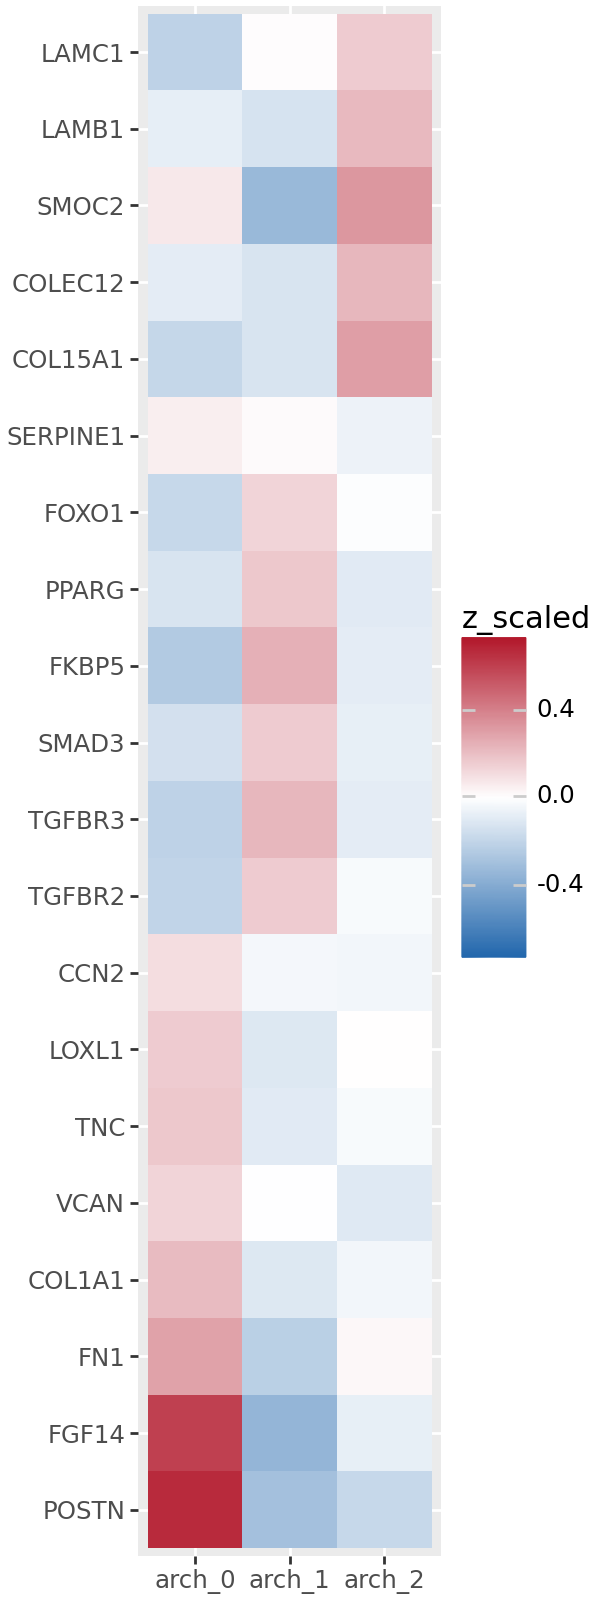

In [66]:
# ---------------------------------------------------------------------
# Curated fibroblast archetype marker panel
# Ordered by biological modules (top → bottom in heatmap)
# ---------------------------------------------------------------------
gene_list = [
    # --------------------------------------------------------------
    # Activated ECM fibroblasts (arch_0)
    # --------------------------------------------------------------
    "POSTN",
    "FGF14",
    "FN1",
    "COL1A1",
    "VCAN",
    "TNC",
    "LOXL1",
    "SERPINH1",
    "CCN2",
    "CYR61",

    # --------------------------------------------------------------
    # ECM remodeling / turnover
    # --------------------------------------------------------------
    #"MRC2",
    #"MMP2",
    #"TIMP1",
    #"TIMP2",

    # --------------------------------------------------------------
    # Stress / regulatory fibroblasts (arch_1)
    # --------------------------------------------------------------
    "TGFBR2",
    "TGFBR3",
    "SMAD3",
    "FKBP5",
    "PPARG",
    "FOXO1",
    "SERPINE1",

    # --------------------------------------------------------------
    # Perivascular / basement-membrane fibroblasts (arch_2)
    # --------------------------------------------------------------
    "COL15A1",
    "COLEC12",
    "SMOC2",
    "LAMB1",
    "LAMC1",
    #"RGS5",

    # --------------------------------------------------------------
    # Quiescent / resident fibroblasts
    # --------------------------------------------------------------
    #"PDGFRA",
    #"DCN",
    #"LUM",
]

# ---------------------------------------------------------------------
# Subset and preserve ordering
# ---------------------------------------------------------------------
plot_df = (
    arch_expr_long
    .loc[arch_expr_long["gene"].isin(gene_list), :]
    .assign(
        gene=lambda df: pd.Categorical(
            df["gene"],
            categories=gene_list,
            ordered=True,
        )
    )
)

genes_sufficient_expression = (
    plot_df
    .groupby("gene")
    .agg({"raw": "min"})
    .reset_index()
    .query("raw > 0.05")["gene"]
    .to_list()
)

plot_df = (
    arch_expr_long
    .loc[arch_expr_long["gene"].isin(genes_sufficient_expression), :]
    .assign(
        gene=lambda df: pd.Categorical(
            df["gene"],
            categories=[g for g in gene_list if g in genes_sufficient_expression],
            ordered=True,
        )
    )
)

# ---------------------------------------------------------------------
# Heatmap
# ---------------------------------------------------------------------
p = (
    pn.ggplot(plot_df)
    + pn.geom_tile(pn.aes(y="gene", x="archetype", fill="z_scaled"))
    + pn.scale_fill_gradient2(
        low="#2166AC",
        mid="#FFFFFF",
        high="#B2182B",
        midpoint=0,
        limits=(-0.75, 0.75),
        oob=squish,
    )
    + pn.theme(
        axis_title_y=pn.element_blank(),
        axis_title_x=pn.element_blank(),
        figure_size=(3, 8)
    )
)

p.show()

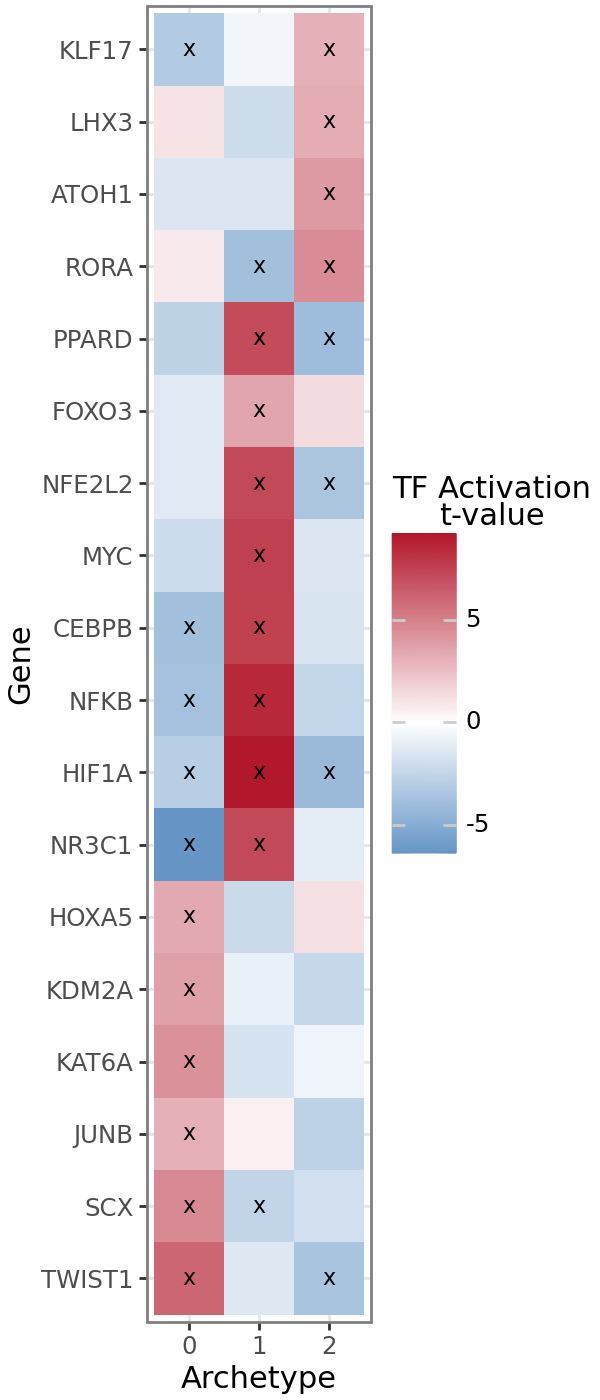

In [ ]:
marker_blocks = {
    0: {
        "function": "activated fibrotic ECM fibroblasts (POSTN+ / FGF14+; matrix deposition & stiffening)",
        "genes": [
            # core fibrotic activation / matrifibrocyte-like ECM
            "POSTN",
            "FGF14",
            "FN1",
            "COL1A1",
            "VCAN",
            "TNC",
            "LOXL1",
            # pro-fibrotic signaling / matrix interaction
            "CCN2",
            # optional: niche / turnover link (kept because it separated in your plot)
            "MRC2",
        ],
        "TFs": [
            # activation / mesenchymal reprogramming
            "TWIST1",
            "SCX",
            "JUNB",
            # chromatin-associated activation (present in your plot; interpretable)
            "KAT6A",
            "KDM2A",
            # positional / fibroblast program component
            "HOXA5",
        ],
    },
    1: {
        "function": "stress-responsive / regulatory fibroblasts (TGF-β sensing; glucocorticoid/hypoxia/inflammation integration)",
        "genes": [
            # direct stress/regulatory anchors observed in your summary
            "FKBP5",
            "PPARG",
            "FOXO1",
            "TGFBR2",
            "TGFBR3",
            "SMAD3",
            # optional: canonical TGF-β output (include if present in var_names)
            "SERPINE1",
        ],
        "TFs": [
            # hormonal stress axis
            "NR3C1",
            # hypoxia / stress
            "HIF1A",
            # inflammation / immediate early
            "NFKB",
            "CEBPB",
            # metabolic scaling / stress response
            "MYC",
            "NFE2L2",
            # resilience / anti-fibrotic stress buffering
            "FOXO3",
            # lipid metabolism regulator (appears in your plot)
            "PPARD",
        ],
    },
    2: {
        "function": "perivascular / basement-membrane fibroblasts (vascular-adjacent niche; COL15A1+ / SMOC2+ / laminins)",
        "genes": [
            "COL15A1",
            "COLEC12",
            "SMOC2",
            "LAMB1",
            "LAMC1",
            # perivascular adjacency marker (keep; serves as boundary check vs pericytes)
            "RGS5",
        ],
        "TFs": [
            # strongest arch_2 TFs from your printed ULM output
            "RORA",
            "ATOH1",
            "LHX3",
            "KLF17",
            # optional, if present/robust in your full TF tile:
            # "NR2F2", "PROX1"
        ],
    },
}

# ---------------------------------------------------------------------
# Derive ordered gene_list and tf_list for plotting (deduplicated)
# ---------------------------------------------------------------------
gene_list = []
for a in range(n_archetypes):
    gene_list += marker_blocks[a]["genes"]
seen = set()
gene_list = [g for g in gene_list if not (g in seen or seen.add(g))]

tf_list = []
for a in range(n_archetypes):
    tf_list += marker_blocks[a]["TFs"]
seen = set()
tf_list = [tf for tf in tf_list if not (tf in seen or seen.add(tf))]

n_archetypes=3

collectri = dc.op.collectri(organism="human")
collectri_acts_ulm_est, collectri_acts_ulm_est_p = dc.mt.ulm(
    data=arch_expr["z_scaled"], net=collectri, verbose=False
)

df_1 = collectri_acts_ulm_est.reset_index(names="archetype").melt(
    id_vars="archetype", var_name="TF", value_name="t_value"
)
df_2 = collectri_acts_ulm_est_p.reset_index(names="archetype").melt(
    id_vars="archetype", var_name="TF", value_name="p_value"
)
collectri_df = df_1.join(df_2.set_index(["archetype", "TF"]), on=["archetype", "TF"])
collectri_df.to_csv(output_dir / "collectri_df.csv", index=False)
del df_1, df_2

plot_df = collectri_df
plot_df = plot_df.loc[plot_df["TF"].isin(tf_list), :].copy()
plot_df["TF"] = pd.Categorical(plot_df["TF"], categories=tf_list, ordered=True)
arch_order = [f"{idx}" for idx in range(n_archetypes)]
plot_df["archetype"] = pd.Categorical(
    plot_df["archetype"], categories=arch_order, ordered=True
)
p_sig = 0.05
sig_df = plot_df.loc[plot_df["p_value"] <= p_sig].copy()
p = (
    pn.ggplot(plot_df, pn.aes(y="TF", x="archetype", fill="t_value"))
    + pn.geom_tile()
    + pn.geom_text(
        data=sig_df,
        mapping=pn.aes(y="TF", x="archetype"),
        label="x",
        size=8,
        color="black",
    )
    + pn.scale_fill_gradient2(
        low="#2166AC",
        mid="#FFFFFF",
        high="#B2182B",
        midpoint=0,
        oob=squish,
    )
    + pn.theme_bw()
    + pn.theme(
        figure_size=(3, 7),
    )
    + pn.labs(y="Gene", x="Archetype", fill="TF Activation\nt-value")
)
p.show()

In [80]:
collectri_df.query("p_value<0.05").query("archetype=='2'").sort_values("t_value", ascending=False)

,archetype,TF,t_value,p_value
1493,2,RORA,4.660520,0.000433
71,2,ATOH1,4.052692,0.002041
1472,2,REST,3.756872,0.005691
338,2,ERF,3.698204,0.006550
1931,2,ZBTB18,3.564578,0.009083
887,2,LHX3,3.301731,0.018846
1331,2,PBX2,3.221199,0.022390
848,2,KLF17,3.200835,0.023432
563,2,HDAC3,3.087960,0.029962
1970,2,ZGLP1,3.045110,0.033137
